In [1]:
import os
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from glob import glob
from scipy.stats import ttest_1samp
import scikit_posthocs as sp
from typing import defaultdict
from scipy import stats
from cycler import cycler

In [2]:
# Step 1: Load all dictionaries from markdown files
results = []

for filepath in glob("*.md"):
    model_name = os.path.splitext(os.path.basename(filepath))[0]
    with open(filepath, "r") as f:
        content = f.read()
    dicts = re.findall(r"results_dict\s*=\s*({.*?})", content, re.DOTALL)
    for d in dicts:
        parsed = ast.literal_eval(d)
        for benchmark, score in parsed.items():
            results.append({
                "model": model_name,
                "benchmark": benchmark,
                "score": score
            })

df = pd.DataFrame(results)

In [3]:
df["benchmark"] = df["benchmark"].map(lambda s: s.split("_")[0].replace("CHEMBL", ""))

In [4]:
win_tracker = defaultdict(int)

n_benchmarks = len(df["benchmark"].unique())
alpha = 0.05
xerr_dict = {}
for i, (model, model_df) in enumerate(df.groupby("model", sort=False)):
    xerr_dict[model] = {}
    for j, (benchmark, bench_df) in enumerate(model_df.groupby("benchmark", sort=False)):
        result = ttest_1samp(bench_df["score"], 0.0, alternative="greater")
        xerr_dict[model][benchmark] = abs(result.confidence_interval(1 - alpha).low - bench_df["score"].mean())
        if result.pvalue < alpha:
            ...  # mean is practically less than zero
        else:
            win_tracker[model] += 1

results = pd.DataFrame.from_records(
    [{
        "Model": model.replace("_", " "),
        "Consistent Count": win_count,
        "Consistency Rate (%)": 100 * win_count / n_benchmarks,
    } for model, win_count in win_tracker.items()
    ], index="Model").sort_values(by="Consistency Rate (%)", axis=0, ascending=False)
results.round(1)


,Consistent Count,Consistency Rate (%)
Model,,
ChemProp Direct,9,31.0
ChemProp Pretrained,5,17.2
MoLFormer,3,10.3
RF Morgan,3,10.3


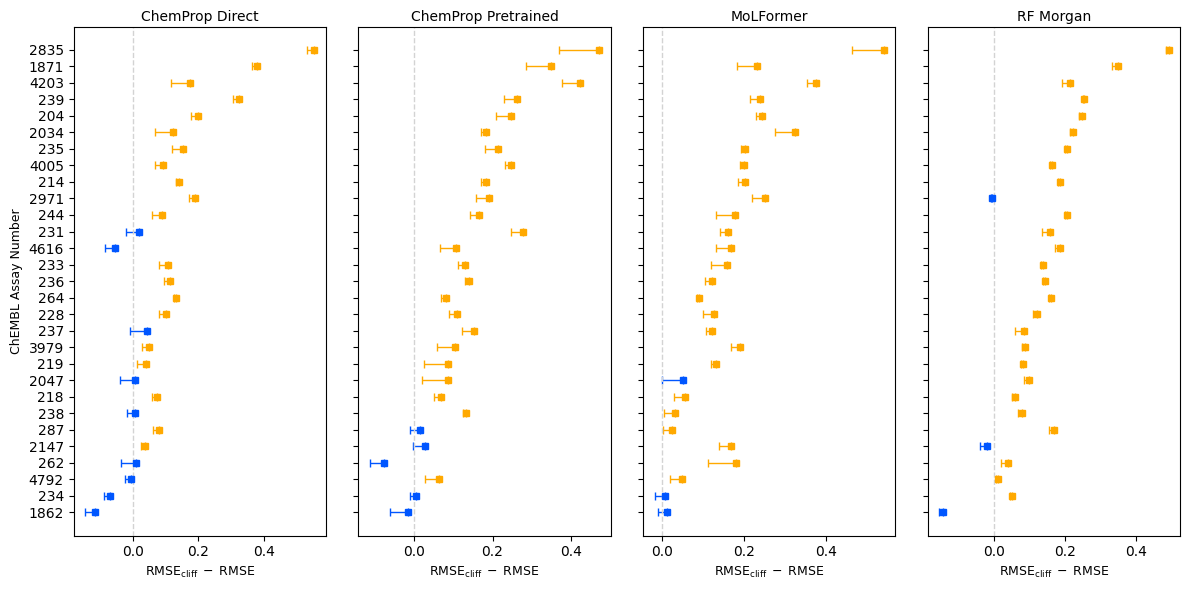

In [5]:
order = (df.groupby("benchmark")["score"]
           .median()
           .sort_values(ascending=True)
           .index)
y_pos = np.arange(len(order))

models  = sorted(df["model"].unique())
n_models = len(models)
fig, axes = plt.subplots(1, n_models,
                         figsize=(3*n_models, 6),
                         sharey=True)

for i, (ax, mod) in enumerate(zip(axes, models)):
    sub = df[df["model"] == mod]
    means = sub.groupby("benchmark")["score"].mean()[order]
    for j in range(means.shape[0]):
        bmark = means.index[j]
        ax.errorbar(means[bmark], y_pos[j],
                    xerr=np.array([[xerr_dict[mod][bmark], 0]]).T,
                    fmt='s', markersize=4, capsize=3, lw=1,
                    color="#0056FF" if (means[bmark] - xerr_dict[mod][bmark]) <= 0.0 else "#FFA900"
        )
    
    ax.axvline(0, color="lightgrey", lw=1, linestyle='--')
    ax.set_title(mod, fontsize=10, pad=4)
    ax.set_xlabel(r"$\mathrm{RMSE_{cliff}\;-\;RMSE}$", fontsize=9)
    
    if i == 0:
        ax.set_yticks(y_pos)
        ax.set_yticklabels(order.to_list())
        ax.set_ylabel("ChEMBL Assay Number", fontsize=9)

plt.tight_layout(w_pad=2)
plt.show()